## **CONTEXT: Plant Seedlings Classification**
University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at
various stages of growth. They already have have invested on curating sample images. They require an automation which can create a
classifier capable of determining a plant's species from a photo.

• PROJECT OBJECTIVE: To create a classifier capable of determining a plant's species from a photo.

### **Import and understand the data**

In [ ]:
import os
import pandas as pd
import zipfile
import numpy as np
import PIL
import cv2
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Activation,LeakyReLU
from tensorflow.keras.optimizers import Adam,SGD
import shutil
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image
import matplotlib.image as mpimg

In [31]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls  '/content'

drive  sample_data


#### **A. Extract from zip file and copy to /content**

In [ ]:
# extract the zip files
path=r'C:\Users\prasa\OneDrive\Desktop\GreatLearning\ComputerVision\AddlProject\plant-seedlings-classification2.zip'
with zipfile.ZipFile(path,mode='r') as zs:
    zs.extractall(os.path.join(r'C:\Users\prasa\OneDrive\Desktop\GreatLearning\ComputerVision\AddlProject','extraced'))


In [ ]:
 #copy the files from drive to /content
!cp -r '/content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/extraced/plant-seedlings-classification/plant-seedlings-classification/train' /content/images

#### **B. Map the images from train folder with train labels to form a DataFrame.**

In [ ]:


def images_to_dataframe(directory):
    data = []

    # Iterate through each species folder
    for species in os.listdir(directory):
        species_path = os.path.join(directory, species)

        if os.path.isdir(species_path):  # Ensure it's a directory
            for image_name in os.listdir(species_path):
                image_path = os.path.join(species_path, image_name)

                try:
                    image = cv2.imread(image_path)  # Read image
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                    data.append([image_name, species, image])
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    df = pd.DataFrame(data, columns=["imagename", "Species", "image"])
    return df


# Example usage
directory = r'/content/images'
df = images_to_dataframe(directory)
print(df.head())

       imagename           Species  \
0  d0bd8f934.png  Common Chickweed   
1  41e3d1276.png  Common Chickweed   
2  ce19a867c.png  Common Chickweed   
3  dd76f845f.png  Common Chickweed   
4  9b3f2f7a1.png  Common Chickweed   

                                               image  
0  [[[92, 80, 62], [90, 79, 61], [90, 78, 59], [8...  
1  [[[178, 185, 192], [182, 188, 195], [178, 183,...  
2  [[[91, 65, 43], [89, 64, 42], [91, 68, 46], [1...  
3  [[[64, 53, 39], [59, 49, 36], [56, 47, 37], [5...  
4  [[[87, 68, 51], [80, 59, 40], [73, 52, 30], [8...  


#### **C. Write a function that will select n random images and display images along with its species.**

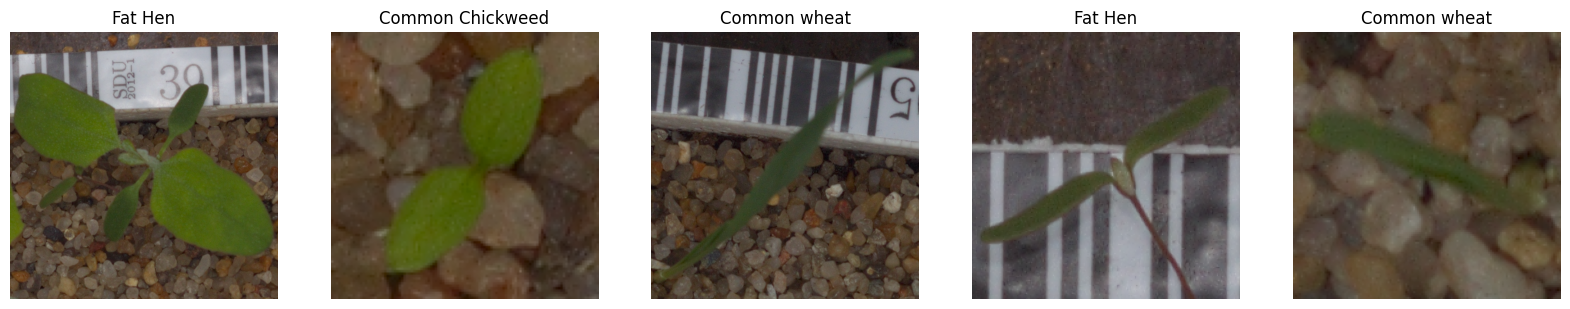

In [ ]:
def display_random_images(df, n):
    sample_images = df.sample(n=min(n, len(df)))  # Select n random samples

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    for ax, (_, row) in zip(axes, sample_images.iterrows()):
        ax.imshow(row["image"])
        ax.set_title(row["Species"])
        ax.axis("off")
    plt.show()
display_random_images(df,5)

#### **2.Data Preprocessing**

In [ ]:
df['image'][0].shape

(124, 124, 3)

##### **Resize the image**

In [ ]:
# resize image
def resizeimg(Image):
    image = cv2.resize(Image,(224, 224),interpolation = cv2.INTER_LINEAR)
    return image
df_plants = df.copy()
df_plants
df_plants['image']=df_plants['image'].apply(resizeimg)
df_plants['image'][0].shape



(224, 224, 3)

##### **Convert image to grayscale**

In [ ]:
# normalize image
def normalizeimage(image):
    # Convert image to BGR for cv2

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert BGR to RGB
    #cv2.imshow("image",image)
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Normalize grayscale image
    normalized_gray_image = cv2.normalize(
        gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Convert normalized grayscale image back to color
    normalized_color_image = cv2.cvtColor(
        normalized_gray_image, cv2.COLOR_GRAY2RGB)
    normalized_color_image = cv2.cvtColor(normalized_gray_image, cv2.COLOR_BGR2RGB)

    return normalized_gray_image



In [ ]:
df_plants['image']=df_plants['image'].apply(normalizeimage)
#normalizeimage(df_plants['image'][0]).shape

array([[ 77,  77,  77, ..., 199, 207, 209],
       [ 77,  77,  77, ..., 199, 209, 209],
       [ 75,  75,  77, ..., 203, 213, 215],
       ...,
       [219, 219, 213, ..., 102, 100, 100],
       [215, 215, 211, ..., 102, 102, 102],
       [215, 215, 211, ..., 102, 102, 102]], dtype=uint8)
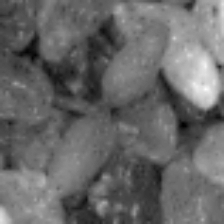

In [ ]:
df_plants['image'][8]

##### **3.A. Split data into Train and Test**

In [ ]:
# train test split
# Create X and Y from data frame
#X =df_plants.drop(['Species','imagename'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(df_plants['image'],df_plants['Species'],test_size=0.2,random_state=42)

In [ ]:
#print(X_train[:10])
print(X_train.iloc[8])

[[150 139 129 ... 126 139 150]
 [141 133 118 ... 133 144 150]
 [131 120 105 ... 144 148 150]
 ...
 [126 124 120 ... 114 111 114]
 [126 122 118 ... 111 111 111]
 [126 122 116 ... 109 111 114]]


##### **B.Label Encoding**

In [ ]:
# Label encoding
label_encoder = LabelEncoder()
y_train_en= label_encoder.fit_transform(y_train)

y_test_en= label_encoder.fit_transform(y_test)

In [ ]:
X_train.shape[0]

3800

##### **2. C & D Unify shape and normalize the image**

In [ ]:
# Normalizing the image pixels
X_train_normalized = []
X_test_normalized = []

# Iterate through the Series and normalize each image individually
for image_array in X_train:
    normalized_image = image_array.astype('float32') / 255.0
    X_train_normalized.append(normalized_image)

for image_array in X_test:
    normalized_image = image_array.astype('float32') / 255.0
    X_test_normalized.append(normalized_image)


X_train_normalized = np.array(X_train_normalized)
X_train_normalized = X_train_normalized.reshape(X_train_normalized.shape[0], 224, 224, 1)
X_test_normalized = np.array(X_test_normalized)
X_test_normalized = X_test_normalized.reshape(X_test_normalized.shape[0], 224, 224, 1)

In [ ]:
print(X_train_normalized[0].shape)

(224, 224, 1)


In [ ]:
# Creating one-hot encoded representation of target labels
# We can do this by using this utility function - https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
# to_categorical() function is also explained in the Neural Networks Module

y_train_encoded = tf.keras.utils.to_categorical(y_train_en)
y_test_encoded = tf.keras.utils.to_categorical(y_test_en)

### **Defining an Artificial Neural Network (ANN) Model**

Let's first create an ANN model as we have done previously.

We will create this ANN sequentially, by adding the layers one after another.
First, let's **set the seed for the random number generators in Numpy, Python's Random package, and TensorFlow** to ensure we are able to reproduce these results every time we run the code.

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
X_test_normalized.shape

(950, 224, 224, 1)

In [ ]:
#Reshape the image
X_train_normalized = np.array(X_train_normalized)
X_train_normalized = X_train_normalized.reshape(X_train_normalized.shape[0],224,224,1)
X_test_normalized =  np.array(X_test_normalized)
X_test_normalized =  X_test_normalized.reshape(X_test_normalized.shape[0],224,224,1)

### **3.Model Training**

#### **Let us now build a sequential ANN Model**

In [ ]:
# Intializing a sequential model
ann_model = Sequential()

# Flatten the input to add dense convolutional layers on top of it
ann_model.add(Flatten(input_shape=(224, 224)))

# Adding a sequential layer with 100 neurons
ann_model.add(Dense(128, activation='relu'))
# Adding a sequential layer with 100 neurons
ann_model.add(Dense(64, activation='relu'))
# Adding a sequential layer with 100 neurons
ann_model.add(Dense(32, activation='relu'))

# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
ann_model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
ann_model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Generating the summary of the model
ann_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,433,388 (24.54 MB)

 Trainable params: 6,433,388 (24.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ann_model.fit(X_train_normalized,y_train_encoded,epochs=15,batch_size=64,validation_split=0.1,shuffle=True,verbose=2)

Epoch 1/15
54/54 - 7s - 134ms/step - accuracy: 0.1284 - loss: 2.4715 - val_accuracy: 0.1263 - val_loss: 2.4657
Epoch 2/15
54/54 - 8s - 148ms/step - accuracy: 0.1345 - loss: 2.4422 - val_accuracy: 0.1263 - val_loss: 2.4404
Epoch 3/15
54/54 - 6s - 108ms/step - accuracy: 0.1345 - loss: 2.4223 - val_accuracy: 0.1342 - val_loss: 2.4319
Epoch 4/15
54/54 - 4s - 72ms/step - accuracy: 0.1287 - loss: 2.4147 - val_accuracy: 0.1342 - val_loss: 2.4296
Epoch 5/15
54/54 - 5s - 97ms/step - accuracy: 0.1275 - loss: 2.4117 - val_accuracy: 0.1342 - val_loss: 2.4294
Epoch 6/15
54/54 - 9s - 158ms/step - accuracy: 0.1275 - loss: 2.4105 - val_accuracy: 0.1342 - val_loss: 2.4297
Epoch 7/15
54/54 - 5s - 100ms/step - accuracy: 0.1275 - loss: 2.4099 - val_accuracy: 0.1342 - val_loss: 2.4302
Epoch 8/15
54/54 - 4s - 68ms/step - accuracy: 0.1278 - loss: 2.4097 - val_accuracy: 0.1342 - val_loss: 2.4307
Epoch 9/15
54/54 - 6s - 108ms/step - accuracy: 0.1278 - loss: 2.4096 - val_accuracy: 0.1342 - val_loss: 2.4311
Epoc

#### **3.B Model Building - Convolutional Neural Network (CNN)**
Let's create a CNN model sequentially, where we will be adding the layers one after another.
n Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.
Also, let's fix the seed again after clearing the backend.
Let's set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow to be able to reproduce the same results every time we run the code.

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(24)
random.seed(24)
tf.random.set_seed(24)

##### Let's build a **CNN Model**.<br>

The model has 2 main parts:
1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers for prediction.**<br><br>

The flow of our model would be as shown below:

In [ ]:
cmodel = Sequential()

In [ ]:
cmodel.add(Conv2D(64, (3, 3), activation='relu',padding='same', input_shape=(224, 224, 1)))

In [ ]:
cmodel.add(MaxPooling2D((2,2),padding='same'))

In [ ]:
cmodel.add(Conv2D(32, (3, 3), activation='relu',padding='same'))

In [ ]:
cmodel.add(MaxPooling2D((2,2),padding='same'))

In [ ]:
cmodel.add(Conv2D(16, (3, 3), activation='relu',padding='same'))

In [ ]:
cmodel.add(MaxPooling2D((2,2),padding='same'))

In [ ]:
cmodel.add(Flatten())

In [ ]:
cmodel.add(Dense(64, activation='relu'))

In [ ]:
cmodel.add(Dropout(0.2))

In [ ]:
cmodel.add(Dense(32, activation='relu'))

In [ ]:
cmodel.add(Dense(12, activation='softmax'))

In [ ]:
opt = SGD(learning_rate=0.01, momentum=0.9)

In [ ]:
cmodel.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
cmodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 112, 112, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │             396 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 829,084 (3.16 MB)

 Trainable params: 829,084 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

##### **CheckPoint function**

In [ ]:
import os
checkpoint_path = "/content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/chp.weights.h5"

checkpoint_dir = os.path.dirname(checkpoint_path)

 # Create checkpoint  callback
cp_callback =ModelCheckpoint(checkpoint_path,monitor='val_acc',save_weights_only=True,verbose=2)



##### **3C.Training the model**

In [ ]:
history1 = cmodel.fit(X_train_normalized, y_train_encoded, epochs=15, batch_size=64, validation_split=0.2, shuffle=True, verbose=2,callbacks=[cp_callback])

Epoch 1/15
54/54 - 411s - 8s/step - accuracy: 0.1322 - loss: 2.4398 - val_accuracy: 0.1421 - val_loss: 2.4226
Epoch 2/15
54/54 - 431s - 8s/step - accuracy: 0.1418 - loss: 2.4038 - val_accuracy: 0.1526 - val_loss: 2.3990
Epoch 3/15
54/54 - 408s - 8s/step - accuracy: 0.1579 - loss: 2.3808 - val_accuracy: 0.1421 - val_loss: 2.3779
Epoch 4/15
54/54 - 447s - 8s/step - accuracy: 0.1848 - loss: 2.3409 - val_accuracy: 0.1684 - val_loss: 2.3834
Epoch 5/15
54/54 - 402s - 7s/step - accuracy: 0.2085 - loss: 2.2851 - val_accuracy: 0.2000 - val_loss: 2.3509
Epoch 6/15
54/54 - 446s - 8s/step - accuracy: 0.2254 - loss: 2.2414 - val_accuracy: 0.1763 - val_loss: 2.3453
Epoch 7/15
54/54 - 430s - 8s/step - accuracy: 0.2518 - loss: 2.1774 - val_accuracy: 0.1974 - val_loss: 2.3109
Epoch 8/15
54/54 - 407s - 8s/step - accuracy: 0.2871 - loss: 2.0953 - val_accuracy: 0.1789 - val_loss: 2.3915
Epoch 9/15
54/54 - 438s - 8s/step - accuracy: 0.3383 - loss: 1.9474 - val_accuracy: 0.2079 - val_loss: 2.3399
Epoch 10/1

##### **Model Evaluation**

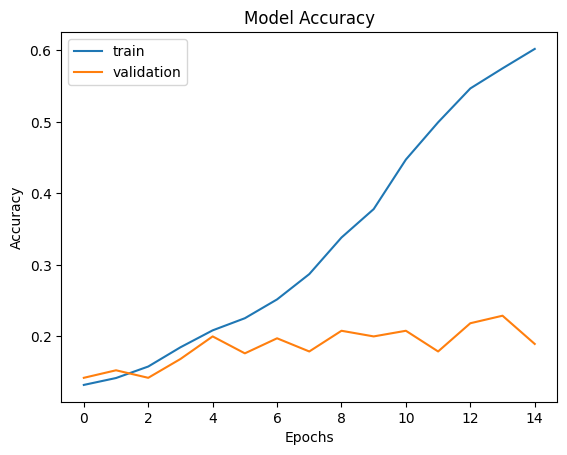

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'],loc='upper left')
plt.show()

##### **Evaluation on Test data**

In [ ]:
accuracy = cmodel.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 28s - 939ms/step - accuracy: 0.1926 - loss: 3.3326


In [ ]:
y_pred = cmodel.predict(X_test_normalized)

30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 960ms/step


In [ ]:
y_test_sp = df_plants.loc[y_test.index,'Species']
#y_test_esp = df_plants.loc[y_test_en.index,'Species']

In [ ]:
print(y_pred[0:10],y_test_en[0:10],y_test_sp[0:10],y_test.unique())

[[8.15154985e-03 3.22291851e-02 4.31004502e-02 3.75914909e-02
  6.61656335e-02 6.20625764e-02 3.67833078e-02 8.60401839e-02
  2.43152812e-01 1.34644672e-01 1.39435589e-01 1.10642537e-01]
 [5.46182506e-03 3.02331243e-03 3.75404246e-02 2.08859488e-01
  1.75483003e-01 1.40285701e-01 1.83521017e-01 7.80082121e-02
  1.51526079e-01 6.85149012e-03 5.09468280e-03 4.34482051e-03]
 [6.93964015e-04 6.20616542e-04 1.37693787e-04 3.10266856e-02
  1.78536270e-02 4.72156593e-04 2.49783024e-02 2.03767885e-03
  7.92839885e-01 1.39058903e-02 1.05185986e-01 1.02474950e-02]
 [5.80577971e-03 3.57841067e-02 5.76790981e-02 4.35414836e-02
  5.19399606e-02 2.97329754e-01 7.01710284e-02 1.55581934e-02
  1.59345001e-01 2.05351859e-01 2.65894718e-02 3.09042092e-02]
 [1.70183612e-05 8.03184375e-05 1.40995837e-07 3.01511306e-03
  3.30623938e-03 6.32012554e-04 9.63672459e-01 2.42891823e-04
  2.43772212e-02 3.75984819e-04 1.60274224e-03 2.67794542e-03]
 [7.67694786e-04 8.22218973e-03 1.71491608e-03 2.21797191e-02
  9

##### **Predictions**

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)[:10]
y_test_arg=np.argmax(y_test_encoded,axis=1)[:10]
y_pred_arg,y_test_arg

(array([ 8,  3,  8,  5,  6, 10,  2,  8,  1, 10]),
 array([10,  7,  6,  3,  3,  9, 10, 10,  1,  3]))

##### **Changing the optimizer and saving weights**

In [ ]:
# model configuration: Create a sequential ANN model
model = Sequential()
# add input later
model.add(Input(shape=(224,224,1)))
# add a Conv2D Layer
model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
# add a MaxPooling lyer
model.add(MaxPooling2D((2,2),padding='same'))
# add a Conv2D Layer
model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
# add a MaxPooling lyer
model.add(MaxPooling2D((2,2),padding='same'))
# add a Conv2D Layer of 32 filters
model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
# add a MaxPooling lyer
model.add(MaxPooling2D((2,2),padding='same'))
# add a Flatten layer for input to FNN
model.add(Flatten())
# add a Dense layer with 64 neurons
model.add(Dense(64,activation='relu'))
# add a drop out layer
model.add(Dropout(0.2))
# add a Dense layer with 32 neurons
model.add(Dense(32,activation='relu'))
# add a drop out layer
#model.add(Dropout(0.2))
# add a Dense layer
model.add(Dense(16,activation='relu'))
# add a Dense layer
model.add(Dense(12,activation='softmax'))
# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Generating the summary of the model
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,702,044 (6.49 MB)

 Trainable params: 1,702,044 (6.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#loading saved weights
model.load_weights(checkpoint_path)

##### **Re-training the model with saved weights and optimizer changes**

##### **Model Evaluation**

In [ ]:
history2 = model.fit(X_train_normalized,y_train_encoded,epochs=15,batch_size=64,validation_split=0.2,verbose=2,shuffle=True,callbacks=[cp_callback])

Epoch 1/15

Epoch 1: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/chp.weights.h5
48/48 - 23s - 470ms/step - accuracy: 0.9359 - loss: 0.2107 - val_accuracy: 0.5921 - val_loss: 2.6853
Epoch 2/15

Epoch 2: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/chp.weights.h5
48/48 - 28s - 587ms/step - accuracy: 0.9296 - loss: 0.2101 - val_accuracy: 0.5934 - val_loss: 2.8220
Epoch 3/15

Epoch 3: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/chp.weights.h5
48/48 - 10s - 215ms/step - accuracy: 0.9411 - loss: 0.1821 - val_accuracy: 0.6039 - val_loss: 2.9794
Epoch 4/15

Epoch 4: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/chp.weights.h5
48/48 - 10s - 210ms/step - accuracy: 0.9497 - loss: 0.1600 - val_accuracy: 0.5921 - val_loss: 2.8818
Epoch 5/15

Epoch 5: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/chp.weights.h5
48/48 - 10s - 213ms/s

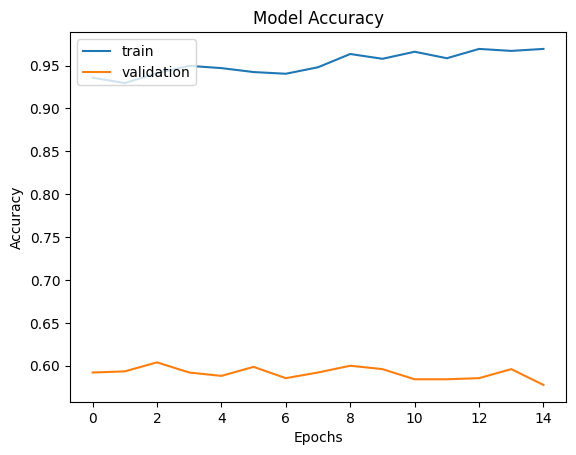

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'],loc='upper left')
plt.show()

In [ ]:
accuracy2 = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

30/30 - 5s - 160ms/step - accuracy: 0.2337 - loss: 6.0469


In [ ]:
y_pred2 = model.predict(X_test_normalized)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


##### **Predicted vs Actual class of the seedlings for 10 images**

In [ ]:
print(np.argmax(y_pred2[0:10],axis=0))
print(y_test_encoded[0:10])
for i in zip(np.argmax(y_pred2[0:10],axis=0),y_test_en[0:10]):
  print(i)

#,np.argmax(y_test_en[0:10]),y_test_sp[0:10])

[1 3 3 9 0 1 6 8 2 3 5 5]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(1, 7)
(3, 10)
(3, 3)
(9, 2)
(0, 1)
(1, 4)
(6, 6)
(8, 6)
(2, 11)
(3, 2)


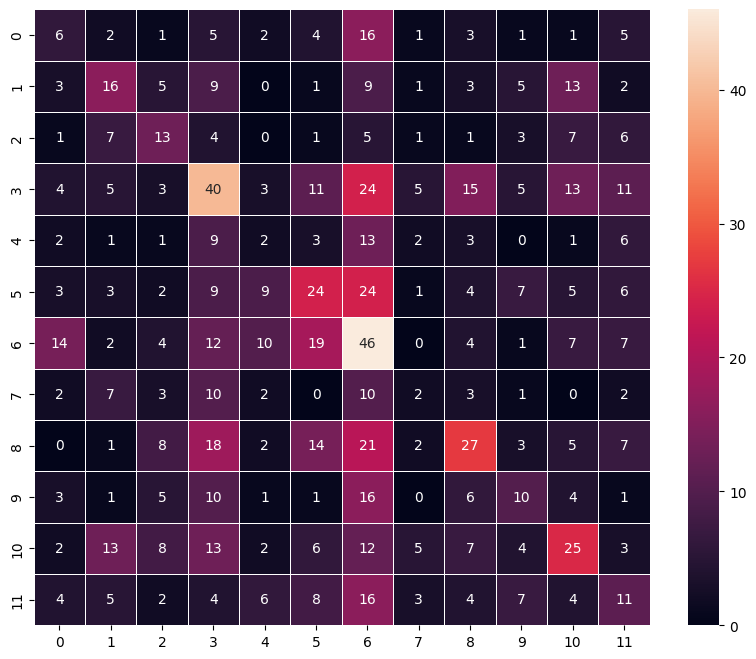

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred2,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [ ]:
y_test_sp = df_plants.loc[y_test.index,'Species']
x_test_sp = df_plants.loc[X_test.index]
print(x_test_sp[0:10])
for i in zip(np.argmax(y_pred2[0:10],axis=0),np.argmax(y_test_encoded[0:10],axis=0),y_test_sp[0:10]['Species']):
  print(i)
#print(X_test.iloc[2].index)
#Assuming X_test.iloc[2] contains the image data as a NumPy array
for i in range(10):
  image_array = X_test.iloc[i]
  #image = mpimg.imread(image_array)
  # Display the image using Matplotlib
  plt.imshow(image_array)  # Use 'gray' colormap if it's a grayscale image
  plt.title("Image from X_test"+str(i))
  plt.show()

### **Observations**
**1. We can see Model overfits with training accuracy at 96% and validation accuracy at 20%. Data Augmentation needs to be done to resolve this problem**

## **DOMAIN: Classification problem of  Oxlower17 dataset**

  **CONTEXT: University X is currently undergoing some research involving understanding the characteristics of flowers. They already have
    have invested on curating sample images. They require an automation which can create a classifier capable of determining a flower’s
    species from a photo.<br>**
  **DATA DESCRIPTION: The dataset comprises of images from 17 plant species.**<br>
    **PROJECT OBJECTIVE: To experiment with various approaches to train an image classifier to predict type of flower from the image**

#### **B.1 Import and Understand the data**
**Note: tflearn datasets for Oxflower17 and tensorflow 1.15 version are not compatible with latest tensorflow , hence downloading the data from npz file**

In [ ]:
# Installations
!pip install tflearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127283 sha256=493102146a89162cff9f156ed149fa86e5d6585692ef912565b761df2c0c6c98
  Stored in directory: /root/.cache/pip/wheels/67/dd/7b/ddc1488c900739f410ea276e0e450d220f69d85c39e421f5f3
Successfully built tflearn


In [ ]:
# for tflearn compatibility
!pip install tensorflow

In [45]:
## import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Input,Activation,Flatten,LeakyReLU,BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.image as mpimg
# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier
#import tflearn.datasets.oxflower17

In [4]:
# import the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### **Import and Read Oxflower17 dataset**

In [48]:
!cp /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/oxflower17.npz /content

In [49]:
!ls /content

17_flowers  drive  oxflower17.npz  sample_data


##### **1.B. Print Number of images and shape of the images.**

In [50]:
# load the data
npzfile = np.load(r'/content/oxflower17.npz')
print(npzfile['X'].shape, npzfile['Y'].shape)

(1360, 224, 224, 3) (1360, 17)


#### **Observations:**
We can see there are 1360 total images and shape of the each image is (224,224,3)

#### **Class distribution**

In [51]:
# No of classes
np.unique(np.argmax(npzfile['Y'],axis=1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [52]:
# One-Hot Encoding to Labels
y_dist=pd.DataFrame()
y_dist['y'] = np.argmax(npzfile['Y'],axis=1)

In [53]:
y_dist['y']

,y
0,2
1,0
2,12
3,15
4,2
...,...
1355,2
1356,16
1357,10
1358,16


##### **1C. Print count of each class from y.**

<Axes: xlabel='y', ylabel='count'>

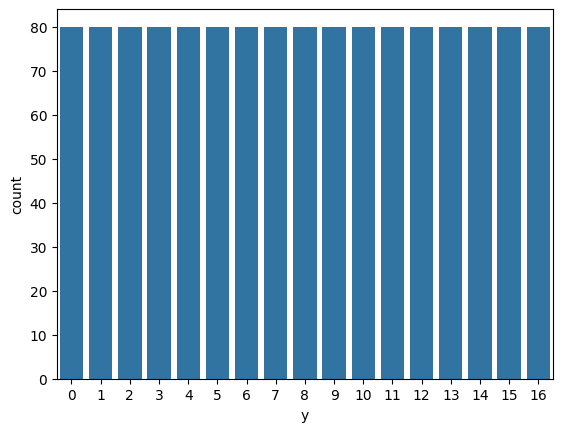

In [54]:
# show distribution of classes
sns.countplot(data=y_dist, x='y')

### **2.Image Exploration and Transformation**

##### **A.Display 5 random images.**

In [55]:
(npzfile['X'][0]).shape

(224, 224, 3)

In [56]:
#Display 5 random images.
def displayImage(lst):

  plt.figure(figsize=(15,15))
  for j in range(len(lst)):
    plt.subplot(1,5,j+1)
    plt.title("class:"+str(np.argmax(npzfile['Y'][lst[j]])))
    plt.imshow(npzfile['X'][lst[j]])



indexes [181 359 456 940 163]


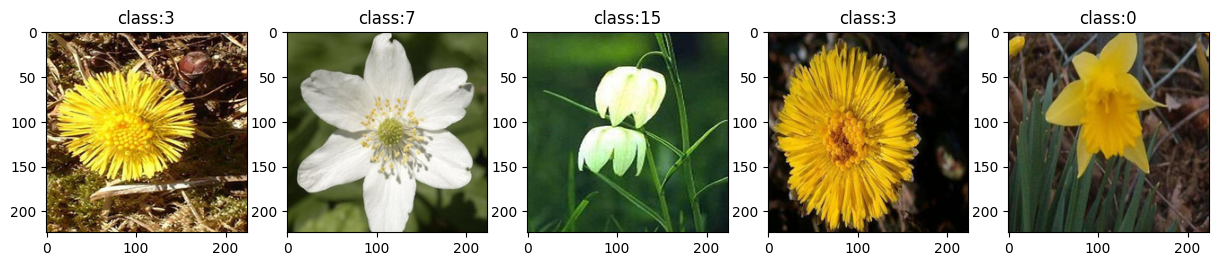

In [57]:
lst=np.random.randint(0,1359,5)
print("indexes",lst)
displayImage(lst)

##### **B & C.Select any image from the dataset and assign it to a variable and convert to gray scale**

In [58]:
#convert to gray scale
def convert2Gray(image):
   image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert BGR to RGB
  #cv2.imshow("image",image)
    # Convert image to grayscale
   gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   return gray_image

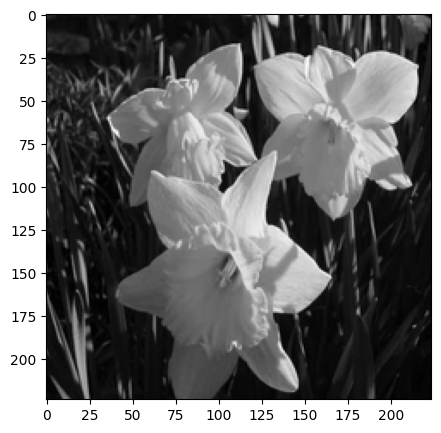

In [59]:
# show the grayscale image
plt.figure(figsize=(5,5))
plt.imshow(convert2Gray(npzfile['X'][64]),cmap='gray')
#plt.imshow(npzfile['X'][0])
plt.show()

#### **D.Apply a filter to sharpen the image and display the image before and after sharpening.**

In [60]:
def sharpenImage(image):
  #plt.subplots(1,2,figsize=(10,10))
  kernel = np.array([[-1,-1,-1],
                   [-1,9,-1],
                   [-1,-1,-1]])
  image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
  return image_sharp

In [61]:
def displayTransImage(orgImage,transImage,title):
  plt.subplot(1,2,1)
  plt.title("before "+title)
  plt.imshow(orgImage)
  plt.subplot(1,2,2)
  plt.title("after "+title)
  plt.imshow(transImage)
  plt.show()

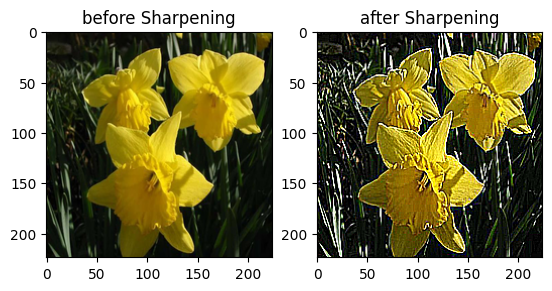

In [62]:
img =sharpenImage(npzfile['X'][64])
displayTransImage(npzfile['X'][64],img,"Sharpening")

#### **E.Apply a filter to blur the image and display the image before and after blurring.**

In [63]:
def blurringImage(image):
  #plt.subplots(1,2,figsize=(10,10))
  kernel = (5,5)
  image_blur = cv2.blur(src=image,ksize=kernel)
  return image_blur

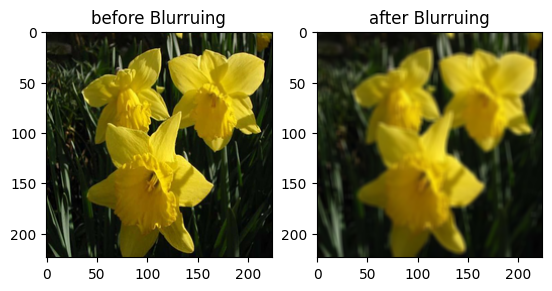

In [64]:
imgb= blurringImage(npzfile['X'][64])
displayTransImage(npzfile['X'][64],imgb,"Blurruing")

#### **F.Transform the image and show all 4 images**

In [67]:
def transformImage(image):
  f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(10,10))
  #print(image.shape)
  # original image
  #plt.subplot(1,4,1)
  ax1.set_title("original image")
  ax1.imshow(image)
  # converting image to gray
  gray_image = convert2Gray(image)
  ##print(gray_image.shape)
  #plt.subplot(1,4,2)
  ax2.set_title("gray image")
  ax2.imshow(gray_image,cmap='gray')
   # sharpening image
  image_sharp = sharpenImage(image)
  ims = np.clip(image_sharp,0.0,0.5)
  #plt.subplot(1,4,3)
  ax3.set_title("sharp image")
  ax3.imshow(ims)
  # blurring image
  blur_image = blurringImage(image)
  #plt.subplot(1,4,4)
  ax4.set_title("blur image")
  ax4.imshow(blur_image,extent=[0,.5,0,.5])
  #plt.show()
  plt.axis('off')

In [65]:
plt.figure(figsize=(10,10))
def displayImageFilters(image,i,title):
  #plt.subplots(1,4,figsize=(10,10))
  ax = plt.subplot(1,4,i)
  plt.imshow(image)
  plt.title(title+" image")
  plt.axis('off')

<Figure size 1000x1000 with 0 Axes>

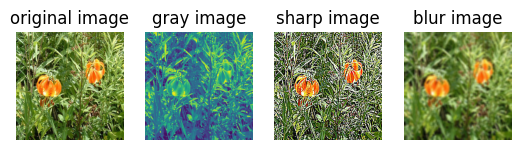

In [66]:
img   = npzfile['X'][40]
displayImageFilters(img,1,"original")
displayImageFilters(convert2Gray(img),2,"gray")
displayImageFilters(sharpenImage(img),3,"sharp")
displayImageFilters(blurringImage(img),4,"blur")

In [68]:
# convert npzfile['Y'] to dataframe
output=pd.DataFrame(np.argmax(npzfile['Y'],axis=1),columns=['op'])
#Get one image from each class


In [69]:
# Get index of each type of class for 1 image
output.groupby('op').head(1)

,op
0,2
1,0
2,12
3,15
7,3
8,9
9,16
10,10
12,8
13,11


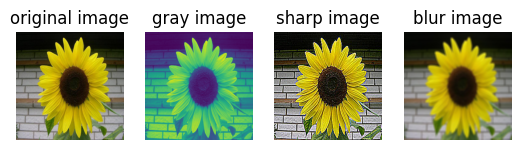

In [70]:
img   = npzfile['X'][9]
displayImageFilters(img,1,"original")
displayImageFilters(convert2Gray(img),2,"gray")
displayImageFilters(sharpenImage(img),3,"sharp")
displayImageFilters(blurringImage(img),4,"blur")

In [71]:
npzfile['Y'][9]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

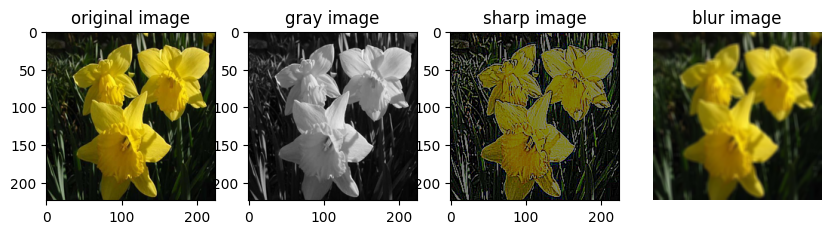

In [72]:
transformImage(npzfile['X'][64])

### **3.Model Training and Tuning**

##### **A. Split the data into train and test with 80:20 proportion.**

In [73]:
# Split X and y into training and test set in 80:20 ratio

X_train, X_test, y_train, y_test = train_test_split(npzfile['X'], npzfile['Y'], test_size=0.20, random_state=24)

In [74]:
# normalize image
def normalizeimage(image):
    # Convert image to BGR for cv2

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert BGR to RGB
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Normalize grayscale image
    normalized_gray_image = cv2.normalize(
        gray_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Convert normalized grayscale image back to color
    normalized_color_image = cv2.cvtColor(
        normalized_gray_image, cv2.COLOR_GRAY2RGB)
    normalized_color_image = cv2.cvtColor(normalized_gray_image, cv2.COLOR_BGR2RGB)
    return normalized_gray_image

In [75]:
d1,d2,d3,d4= X_train.shape

In [80]:
X_train = np.array([normalizeimage(x) for x in X_train ])
X_train.shape
X_test = np.array([normalizeimage(x) for x in X_test ])
X_test.shape

(272, 224, 224)

In [81]:
X_train=X_train.flatten().reshape(1088, 224*224)
X_test=X_test.flatten().reshape(272, 224*224)

#### **B. Train a model using any Supervised Learning algorithm and share performance metrics on test data.**
#### **Build and Train RandomForest Classifier**

In [ ]:
# Building the model
rf_plants = RandomForestClassifier(n_estimators = 100, max_depth = 14, random_state = 24)

# Fitting on train data
rf_plants.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, random_state=24)

In [ ]:
# Predicting on train data
y_pred_train = rf_plants.predict(X_train)

# Predicting on test data
y_pred_test = rf_plants.predict(X_test)

##### **Model Evalulation: F1 Score at 0.9 on training data**

In [ ]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        53
           1       1.00      0.92      0.96        49
           2       1.00      0.95      0.97        55
           3       1.00      0.92      0.96        60
           4       1.00      0.90      0.95        58
           5       1.00      0.89      0.94        64
           6       1.00      0.79      0.88        56
           7       1.00      0.93      0.96        58
           8       1.00      0.93      0.96        59
           9       1.00      0.85      0.92        52
          10       1.00      0.82      0.90        45
          11       1.00      0.95      0.97        60
          12       1.00      0.93      0.96        54
          13       1.00      0.88      0.94        59
          14       1.00      0.84      0.92        58
          15       1.00      0.86      0.93        51
          16       1.00      0.98      0.99        61

   micro avg       1.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### **Model Evalulation: F1 Score at 0.13 on training data**

In [ ]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.11      0.20        27
           1       1.00      0.03      0.06        31
           2       1.00      0.12      0.21        25
           3       1.00      0.30      0.46        20
           4       1.00      0.18      0.31        22
           5       0.00      0.00      0.00        16
           6       1.00      0.08      0.15        24
           7       1.00      0.05      0.09        22
           8       0.00      0.00      0.00        21
           9       0.00      0.00      0.00        28
          10       0.00      0.00      0.00        35
          11       0.00      0.00      0.00        20
          12       1.00      0.31      0.47        26
          13       0.00      0.00      0.00        21
          14       0.00      0.00      0.00        22
          15       0.00      0.00      0.00        29
          16       1.00      0.16      0.27        19

   micro avg       1.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### **Train a model using Artificial Neural Network and share performance metrics on test data.**

In [ ]:
# Split X and y into training and test set in 80:20 ratio

X_train, X_test, y_train, y_test = train_test_split(npzfile['X'], npzfile['Y'], test_size=0.20, random_state=24)

In [ ]:
d1,d2,d3,d4= X_train.shape

In [ ]:
X_train = np.array([normalizeimage(x) for x in X_train ])
print(X_train.shape)
X_test = np.array([normalizeimage(x) for x in X_test ])
print(X_test.shape)

(1088, 224, 224)
(272, 224, 224)


In [ ]:
import os
checkpoint_path = "/content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5"

checkpoint_dir = os.path.dirname(checkpoint_path)

 # Create checkpoint  callback
cp_callback =ModelCheckpoint(checkpoint_path,monitor='val_acc',save_weights_only=True,verbose=2)

In [ ]:
# Intializing a sequential model
ann_model = Sequential()

# Flatten the input to add dense convolutional layers on top of it
ann_model.add(Flatten(input_shape=(224, 224)))
# Adding a sequential layer with 128 neurons
ann_model.add(Dense(200, activation='relu'))
# Adding a sequential layer with 128 neurons
ann_model.add(Dense(128, activation='relu'))
# Adding a sequential layer with 64 neurons
ann_model.add(Dense(64, activation='relu'))
# Adding a sequential layer with 32 neurons
ann_model.add(Dense(32, activation='relu'))
# Dropout
ann_model.add(Dropout(0.2))
# Adding a sequential layer with 16 neurons
ann_model.add(Dense(16, activation='relu'))

# Adding the output layer with 16 neurons and activation functions as softmax since this is a multi-class classification problem
ann_model.add(Dense(17, activation='softmax'))

# Using SGD Optimizer
opt = Adam(learning_rate=0.01)

# Compile model
ann_model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Generating the summary of the model
ann_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 200)                 │      10,035,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 17)                  │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,072,281 (38.42 MB)

 Trainable params: 10,072,281 (38.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# load saved weights
ann_model.load_weights(checkpoint_path)

##### **Train and Save the model**

In [ ]:
hist_ann =ann_model.fit(X_train,y_train,epochs=15,batch_size=64,validation_split=0.2,shuffle=True,verbose=2,callbacks=[cp_callback])

Epoch 1/15

Epoch 1: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 8s - 555ms/step - accuracy: 0.0552 - loss: 7112.1372 - val_accuracy: 0.0550 - val_loss: 1632.0631
Epoch 2/15

Epoch 2: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 4s - 265ms/step - accuracy: 0.0540 - loss: 1158.4045 - val_accuracy: 0.0596 - val_loss: 2.8322
Epoch 3/15

Epoch 3: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 5s - 384ms/step - accuracy: 0.0609 - loss: 26.4367 - val_accuracy: 0.0596 - val_loss: 2.8340
Epoch 4/15

Epoch 4: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 10s - 717ms/step - accuracy: 0.0552 - loss: 2.8407 - val_accuracy: 0.0550 - val_loss: 2.8346
Epoch 5/15

Epoch 5: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5

##### **Model Evaluation**

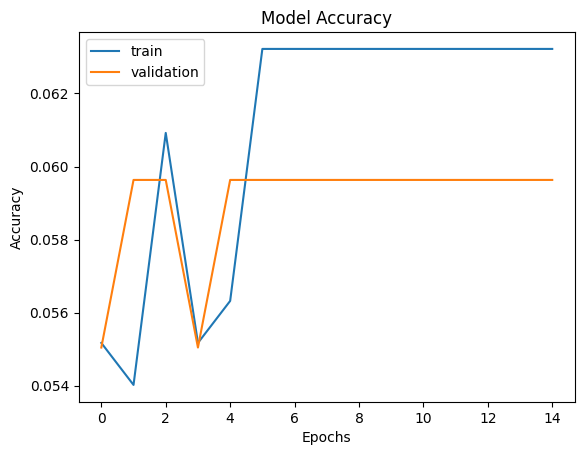

In [ ]:
plt.plot(hist_ann.history['accuracy'])
plt.plot(hist_ann.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'],loc='upper left')

#### **Train a model using a basic CNN and share performance metrics on test**

In [82]:
# Split X and y into training and test set in 80:20 ratio

X_train, X_test, y_train, y_test = train_test_split(npzfile['X'], npzfile['Y'], test_size=0.20, random_state=24)

In [83]:
X_train = np.array([normalizeimage(x) for x in X_train ])
print(X_train.shape)
X_test = np.array([normalizeimage(x) for x in X_test ])
print(X_test.shape)

(1088, 224, 224)
(272, 224, 224)


##### **Model Summary**

In [84]:
 #model configuration: Create a sequential ANN model
model = Sequential()
# add input later
model.add(Input(shape=(224,224,1)))
# add a Conv2D Layer
model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
# add a MaxPooling lyer
model.add(MaxPooling2D((2,2),padding='same'))
# add a Conv2D Layer
model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
# add a MaxPooling lyer
model.add(MaxPooling2D((2,2),padding='same'))
# add a Conv2D Layer of 32 filters
model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
# add a MaxPooling lyer
model.add(MaxPooling2D((2,2),padding='same'))
# add a Flatten layer for input to FNN
model.add(Flatten())
# add a Dense layer with 64 neurons
model.add(Dense(64,activation='relu'))
# add a drop out layer
model.add(Dropout(0.2))
# add a Dense layer with 32 neurons
model.add(Dense(32,activation='relu'))
# add a drop out layer
#model.add(Dropout(0.2))
# add a Dense layer
model.add(Dense(16,activation='relu'))
# add a Dense layer
model.add(Dense(17,activation='softmax'))
# Using SGD Optimizer
#opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 17)                  │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,702,129 (6.49 MB)

 Trainable params: 1,702,129 (6.49 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
#loading saved weights
checkpoint_path=r'/content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5'
model.load_weights(checkpoint_path)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [86]:
# Create checkpoint  callback
cp_callback =ModelCheckpoint(checkpoint_path,monitor='loss',save_weights_only=True,verbose=2)

##### **Train and Save the Model**

In [ ]:
hist_cnn = model.fit(X_train,y_train,epochs=15,batch_size=64,validation_split=0.2,verbose=2,shuffle=True,callbacks=[cp_callback])

Epoch 1/15

Epoch 1: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 259s - 19s/step - accuracy: 0.0713 - loss: 13.1427 - val_accuracy: 0.0734 - val_loss: 2.8191
Epoch 2/15

Epoch 2: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 259s - 19s/step - accuracy: 0.0690 - loss: 2.8184 - val_accuracy: 0.0642 - val_loss: 2.8150
Epoch 3/15

Epoch 3: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 261s - 19s/step - accuracy: 0.1034 - loss: 2.7817 - val_accuracy: 0.0963 - val_loss: 2.8037
Epoch 4/15

Epoch 4: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 263s - 19s/step - accuracy: 0.1230 - loss: 2.6995 - val_accuracy: 0.1147 - val_loss: 2.7937
Epoch 5/15

Epoch 5: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 2

In [ ]:
# Train for another 15 epochs
hist_cnn1 = model.fit(X_train,y_train,epochs=15,batch_size=64,validation_split=0.2,verbose=2,shuffle=True,callbacks=[cp_callback])

Epoch 1/15

Epoch 1: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 240s - 17s/step - accuracy: 0.6759 - loss: 1.0693 - val_accuracy: 0.1468 - val_loss: 4.3156
Epoch 2/15

Epoch 2: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 265s - 19s/step - accuracy: 0.7483 - loss: 0.8912 - val_accuracy: 0.1330 - val_loss: 4.3374
Epoch 3/15

Epoch 3: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 232s - 17s/step - accuracy: 0.7609 - loss: 0.7778 - val_accuracy: 0.1560 - val_loss: 4.4426
Epoch 4/15

Epoch 4: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 272s - 19s/step - accuracy: 0.8092 - loss: 0.6321 - val_accuracy: 0.1514 - val_loss: 5.0843
Epoch 5/15

Epoch 5: saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkp.weights.h5
14/14 - 23

##### **Model Evaluation**

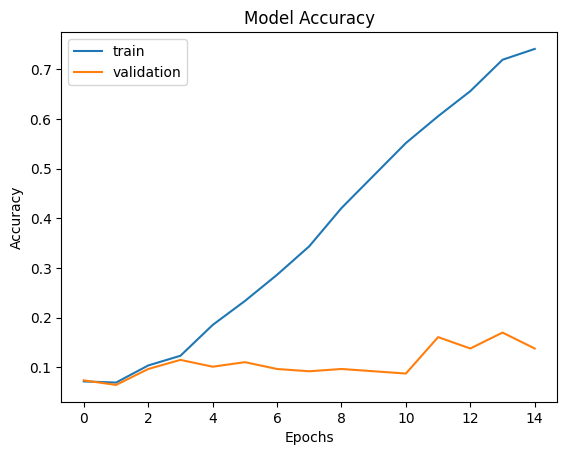

In [ ]:
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'],loc='upper left')

In [ ]:
plt.plot(hist_cnn1.history['accuracy'])
plt.plot(hist_cnn1.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'],loc='upper left')

In [151]:
X_train.shape

(1088, 224, 224)

In [ ]:
# Predicting on train data
y_pred_train = model.predict(X_train)
# Converting predicted probabilities to multilabel-indicator format
y_pred_train = (y_pred_train > 0.5).astype(int)
# Predicting on test data
y_pred_test = model.predict(X_test)
# Converting predicted probabilities to multilabel-indicator format
y_pred_test = (y_pred_test > 0.5).astype(int)

34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step


##### **Classification Report**

In [ ]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82        65
           1       0.82      0.81      0.81        62
           2       0.81      0.81      0.81        62
           3       0.91      0.69      0.78        71
           4       0.94      0.77      0.85        65
           5       0.95      0.53      0.68        68
           6       0.95      0.62      0.75        63
           7       0.88      0.45      0.60        64
           8       0.86      0.81      0.84        63
           9       0.94      0.55      0.69        60
          10       0.76      0.68      0.72        57
          11       0.89      0.60      0.72        68
          12       0.89      0.66      0.75        61
          13       0.86      0.45      0.59        67
          14       0.86      0.58      0.69        66
          15       0.97      0.61      0.75        61
          16       0.98      0.77      0.86        65

   micro avg       0.89   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.50      0.27      0.35        15
           1       0.23      0.17      0.19        18
           2       0.40      0.33      0.36        18
           3       0.33      0.22      0.27         9
           4       0.12      0.07      0.09        15
           5       0.00      0.00      0.00        12
           6       0.20      0.06      0.09        17
           7       0.00      0.00      0.00        16
           8       0.50      0.18      0.26        17
           9       0.00      0.00      0.00        20
          10       0.22      0.09      0.12        23
          11       0.50      0.08      0.14        12
          12       1.00      0.26      0.42        19
          13       0.00      0.00      0.00        13
          14       0.07      0.07      0.07        14
          15       0.00      0.00      0.00        19
          16       0.67      0.13      0.22        15

   micro avg       0.29   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### **Predicted vs Actual**

In [ ]:

#print(x_test_sp[0:10])
for i in zip(np.argmax(y_pred_train[11:20],axis=0),np.argmax(y_train[11:20],axis=0)):
  print("predicted,actual:",i[0],i[1])
  #print(i[0])
#print(X_test.iloc[2].index)
#Assuming X_test.iloc[2] contains the image data as a NumPy array


predicted,actual: 0 0
predicted,actual: 0 0
predicted,actual: 0 0
predicted,actual: 2 2
predicted,actual: 1 1
predicted,actual: 7 6
predicted,actual: 0 0
predicted,actual: 0 0
predicted,actual: 5 5
predicted,actual: 0 0
predicted,actual: 4 4
predicted,actual: 0 0
predicted,actual: 0 0
predicted,actual: 0 8
predicted,actual: 0 0
predicted,actual: 3 3
predicted,actual: 0 0


In [ ]:
y_pred_test.shape
y_pred_test[:10]
np.argmax(y_pred_test[i],axis=0)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
for i in range(11,20,1):
  print("predicted:"+str(np.argmax(y_pred_test[i],axis=0))+"actual:"+str(np.argmax(y_test[i],axis=0)))
 # print(np.argmax(y_test[i],axis=0))
  print("-------")
  #print("predicted,actual:",zip(np.argmax(y_pred_test[i],axis=0),np.argmax(y_test[i],axis=0)))
  #print(

predicted:2actual:2
-------
predicted:10actual:8
-------
predicted:0actual:10
-------
predicted:0actual:3
-------
predicted:11actual:7
-------
predicted:1actual:1
-------
predicted:0actual:10
-------
predicted:0actual:11
-------
predicted:0actual:15
-------


#### **CNN with Data Augmentation**

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:

## import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Input,Activation,Flatten,LeakyReLU,BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.image as mpimg
# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import tflearn.datasets.oxflower17
from tqdm import tqdm # Import the tqdm module

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sanikamal/17-category-flower-dataset")

print("Path to dataset files:", path)

100%|██████████| 57.8M/57.8M [00:00<00:00, 120MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sanikamal/17-category-flower-dataset/versions/1


In [5]:
!cp -r /root/.cache/kagglehub/datasets/sanikamal/17-category-flower-dataset/versions/1/17_flowers /content

In [13]:
!ls  /content/17_flowers/validation/bluebell
#!ls  /content/17_flowers/train/iris | wc -l

image_0241.jpg	image_0243.jpg	image_0245.jpg	image_0247.jpg	image_0249.jpg
image_0242.jpg	image_0244.jpg	image_0246.jpg	image_0248.jpg	image_0250.jpg


In [7]:
import shutil
from distutils.dir_util import copy_tree

trainpath ='/content/17_flowers/train'
valpath ='/content/17_flowers/validation'
dirs = os.listdir(valpath)
#print(dirs)
 # Iterate through files in the source directory
for dr in os.listdir(valpath):
    copy_tree(os.path.join(valpath,dr),os.path.join(trainpath,dr))

/content/17_flowers/train/bluebell/image_0241.jpg


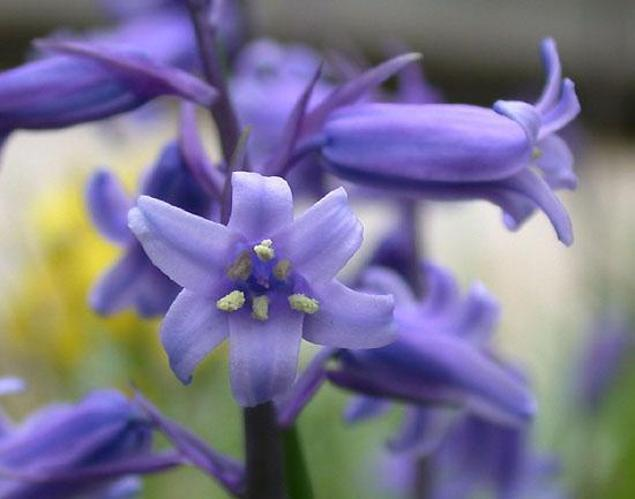

In [15]:
# checking dimensions of a test image
from PIL import Image
import cv2
import numpy as np
IMAGE_SIZE = 128  # Target image size for training and evaluation

test_image_path = '/content/17_flowers/train/bluebell/image_0241.jpg'
print(test_image_path)
test_image = cv2.imread(test_image_path)
#print('Original size of the test_image: ', test_image.shape)
Image.open(test_image_path)


In [16]:
datapath = '/content/17_flowers/train'


# Image augmentation
tr_datagen = ImageDataGenerator(
        #rescale=1./255,
        shear_range=0.2, rotation_range=20,
        zoom_range=0.2, width_shift_range=0.2,
        horizontal_flip=True, vertical_flip=True,
        validation_split=0.2)
val_datagen = ImageDataGenerator(validation_split=0.2) #, rescale=1./255)
tr_generator = tr_datagen.flow_from_directory(
        datapath,
        batch_size=32,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        class_mode='categorical',
        subset='training')
val_generator = val_datagen.flow_from_directory(
        datapath,
        batch_size=32,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        class_mode='categorical',
        subset='validation', shuffle=False)

Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


In [17]:
train_count = tr_generator.samples
print('Number of training Batches: ',int(train_count/32))

Number of training Batches:  34


In [18]:
val_count = val_generator.samples
print('Number of validation Batches: ',int(val_count/32))

Number of validation Batches:  8


In [21]:
# Store the data in X_train, y_train variables by iterating over the batches
tr_generator.reset()
X_train, y_train = next(tr_generator)
for i in tqdm(range(int(train_count/32)-1)):
  img, label = next(tr_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 33/33 [00:11<00:00,  2.88it/s]

(1088, 128, 128, 3) (1088, 17)


In [22]:
# Store the data in X_val, y_val variables by iterating over the batches
val_generator.reset()
X_val, y_val = next(val_generator)
for i in tqdm(range(int(val_count/32)-1)):
  img, label = next(val_generator)
  X_val = np.append(X_val, img, axis=0 )
  y_val = np.append(y_val, label, axis=0)
print(X_val.shape, y_val.shape)

100%|██████████| 7/7 [00:00<00:00,  7.85it/s]

(256, 128, 128, 3) (256, 17)


In [23]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1088, 128, 128, 3) (1088, 17) (256, 128, 128, 3) (256, 17)


In [24]:
# Mapping flower classes to array
flowers_dict = tr_generator.class_indices
print('Available classes: ', flowers_dict)
flowers_dict.values
a = list(flowers_dict.items())
flowers_np = np.array(a)
flowers = flowers_np[:,0]
print('\n After converting the dictionary into simple array: \n', flowers)
print('\n Referencing a class with index: ', flowers[10])

Available classes:  {'bluebell': 0, 'buttercup': 1, 'colts_foot': 2, 'cowslip': 3, 'crocus': 4, 'daffodil': 5, 'daisy': 6, 'dandelion': 7, 'fritillary': 8, 'iris': 9, 'lily_valley': 10, 'pansy': 11, 'snowdrop': 12, 'sunflower': 13, 'tigerlily': 14, 'tulip': 15, 'windflower': 16}

 After converting the dictionary into simple array: 
 ['bluebell' 'buttercup' 'colts_foot' 'cowslip' 'crocus' 'daffodil' 'daisy'
 'dandelion' 'fritillary' 'iris' 'lily_valley' 'pansy' 'snowdrop'
 'sunflower' 'tigerlily' 'tulip' 'windflower']

 Referencing a class with index:  lily_valley


In [25]:
print(y_train[10])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### **CNN model with data augmentation**

In [26]:
cnn_da = Sequential()
cnn_da.add(Conv2D(128, kernel_size=(3,3), padding='same', input_shape=X_train.shape[1:]))
cnn_da.add(BatchNormalization())
cnn_da.add(Activation('relu'))
cnn_da.add(MaxPooling2D(pool_size=(2,2)))
cnn_da.add(Dropout(0.4))

cnn_da.add(Conv2D(64, kernel_size=(3,3), padding='same'))
cnn_da.add(BatchNormalization())
cnn_da.add(Activation('relu'))
cnn_da.add(MaxPooling2D(pool_size=(2,2)))
cnn_da.add(Dropout(0.4))

cnn_da.add(Conv2D(16, kernel_size=(3,3), padding='same'))
cnn_da.add(BatchNormalization())
cnn_da.add(Activation('relu'))
cnn_da.add(Dropout(0.4))

cnn_da.add(Flatten())
cnn_da.add(Dropout(0.4))
cnn_da.add(Dense(17))
cnn_da.add(Activation('softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
# Add Callbacks to pick the best model parameters
checkpoint = ModelCheckpoint(filepath ='/content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5', monitor='loss', mode='min', save_best_only=True, verbose=1)

In [28]:
adam_opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
cnn_da.compile(adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
hist_cnn_da =cnn_da.fit(tr_generator, validation_data=val_generator, steps_per_epoch=int(len(X_train)/32), epochs=24, callbacks=[checkpoint],verbose=2)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24

Epoch 1: loss improved from inf to 4.03251, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 191s - 6s/step - accuracy: 0.1158 - loss: 4.0325 - val_accuracy: 0.2390 - val_loss: 7.5095
Epoch 2/24

Epoch 2: loss improved from 4.03251 to 2.76667, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 210s - 6s/step - accuracy: 0.2739 - loss: 2.7667 - val_accuracy: 0.2426 - val_loss: 6.2231
Epoch 3/24

Epoch 3: loss improved from 2.76667 to 2.41920, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 196s - 6s/step - accuracy: 0.3153 - loss: 2.4192 - val_accuracy: 0.3419 - val_loss: 4.0121
Epoch 4/24

Epoch 4: loss improved from 2.41920 to 2.14725, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 206s - 6s/step - accuracy: 0.3869 - loss: 2.1472 - val_accuracy: 0.4559 - val_loss: 2.5912
Epoch 5/24

Epoch 5: loss improved from 2.14725 to 2.08055, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 195s - 6s/step - accuracy: 0.4007 - loss: 2.0806 - val_accuracy: 0.4007 - val_loss: 2.6842
Epoch 6/24

Epoch 6: loss improved from 2.08055 to 1.98478, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 186s - 5s/step - accuracy: 0.4127 - loss: 1.9848 - val_accuracy: 0.4632 - val_loss: 1.9575
Epoch 7/24

Epoch 7: loss improved from 1.98478 to 1.89523, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 190s - 6s/step - accuracy: 0.4458 - loss: 1.8952 - val_accuracy: 0.3272 - val_loss: 2.5490
Epoch 8/24

Epoch 8: loss improved from 1.89523 to 1.85388, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 200s - 6s/step - accuracy: 0.4660 - loss: 1.8539 - val_accuracy: 0.4007 - val_loss: 2.2127
Epoch 9/24

Epoch 9: loss improved from 1.85388 to 1.63934, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 187s - 6s/step - accuracy: 0.4936 - loss: 1.6393 - val_accuracy: 0.3971 - val_loss: 3.2192
Epoch 10/24

Epoch 10: loss did not improve from 1.63934
34/34 - 202s - 6s/step - accuracy: 0.4715 - loss: 1.7410 - val_accuracy: 0.3750 - val_loss: 2.3837
Epoch 11/24

Epoch 11: loss improved from 1.63934 to 1.61227, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 211s - 6s/step - accuracy: 0.5046 - loss: 1.6123 - val_accuracy: 0.4632 - val_loss: 1.8593
Epoch 12/24

Epoch 12: loss improved from 1.61227 to 1.35914, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 189s - 6s/step - accuracy: 0.5487 - loss: 1.3591 - val_accuracy: 0.4596 - val_loss: 2.4894
Epoch 13/24

Epoch 13: loss did not improve from 1.35914
34/34 - 199s - 6s/step - accuracy: 0.5312 - loss: 1.5021 - val_accuracy: 0.5956 - val_loss: 1.4052
Epoch 14/24

Epoch 14: loss did not improve from 1.35914
34/34 - 214s - 6s/step - accuracy: 0.5377 - loss: 1.4226 - val_accuracy: 0.4375 - val_loss: 1.9683
Epoch 15/24

Epoch 15: loss improved from 1.35914 to 1.35736, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 202s - 6s/step - accuracy: 0.5506 - loss: 1.3574 - val_accuracy: 0.5331 - val_loss: 1.8039
Epoch 16/24

Epoch 16: loss improved from 1.35736 to 1.32918, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 189s - 6s/step - accuracy: 0.5892 - loss: 1.3292 - val_accuracy: 0.5662 - val_loss: 1.5717
Epoch 17/24

Epoch 17: loss improved from 1.32918 to 1.29527, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 197s - 6s/step - accuracy: 0.5634 - loss: 1.2953 - val_accuracy: 0.4816 - val_loss: 1.7940
Epoch 18/24

Epoch 18: loss improved from 1.29527 to 1.26432, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 194s - 6s/step - accuracy: 0.5800 - loss: 1.2643 - val_accuracy: 0.6066 - val_loss: 1.3877
Epoch 19/24

Epoch 19: loss did not improve from 1.26432
34/34 - 198s - 6s/step - accuracy: 0.5836 - loss: 1.3015 - val_accuracy: 0.5478 - val_loss: 1.4511
Epoch 20/24

Epoch 20: loss improved from 1.26432 to 1.18620, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 198s - 6s/step - accuracy: 0.6002 - loss: 1.1862 - val_accuracy: 0.5110 - val_loss: 1.4829
Epoch 21/24

Epoch 21: loss improved from 1.18620 to 1.11685, saving model to /content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5


34/34 - 193s - 6s/step - accuracy: 0.6195 - loss: 1.1168 - val_accuracy: 0.6434 - val_loss: 1.1496
Epoch 22/24

Epoch 22: loss did not improve from 1.11685
34/34 - 190s - 6s/step - accuracy: 0.5892 - loss: 1.2175 - val_accuracy: 0.5625 - val_loss: 1.3806
Epoch 23/24

Epoch 23: loss did not improve from 1.11685
34/34 - 197s - 6s/step - accuracy: 0.6250 - loss: 1.1570 - val_accuracy: 0.6213 - val_loss: 1.4075
Epoch 24/24

Epoch 24: loss did not improve from 1.11685
34/34 - 194s - 6s/step - accuracy: 0.6314 - loss: 1.1488 - val_accuracy: 0.5074 - val_loss: 2.1325


In [35]:
cnn_da.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 16)          │           9,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 17)                  │         278,545 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 17)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,462,694 (5.58 MB)

 Trainable params: 365,569 (1.39 MB)

 Non-trainable params: 416 (1.62 KB)

 Optimizer params: 1,096,709 (4.18 MB)

In [61]:
# Add Callbacks to pick the best model parameters
checkpoint_da = ModelCheckpoint(filepath ='/content/drive/MyDrive/AIML/projects/ComputerVison/AddlProject/checkpoint_da.weights.h5', monitor='loss', mode='min', save_best_only=True, verbose=1)

#### **CNN with Data Augmentation Model Evaluation**

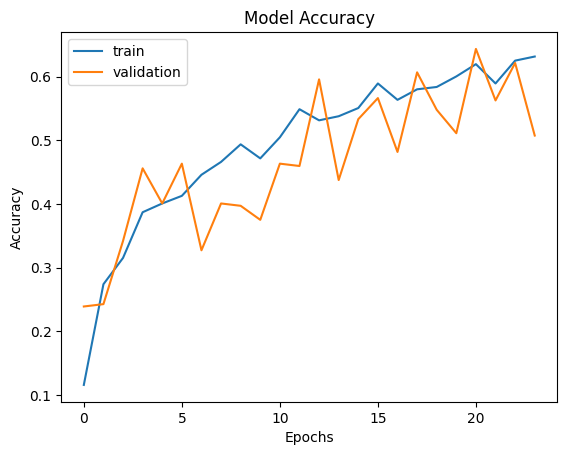

In [36]:
plt.plot(hist_cnn_da.history['accuracy'])
plt.plot(hist_cnn_da.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','validation'],loc='upper left')

In [37]:
# Predicting on train data
y_pred_train = cnn_da.predict(X_train)
# Converting predicted probabilities to multilabel-indicator format
#y_pred_train = np.argmax(y_pred_train, axis=1)
# Predicting on test data
#y_pred_test = cnn_da.predict(X_test)
# Converting predicted probabilities to multilabel-indicator format
#y_pred_test = (y_pred_test > 0.5).astype(int)

34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 933ms/step


In [38]:
# Evaluation validation set
y_pred_test_da= cnn_da.evaluate(val_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 827ms/step - accuracy: 0.4824 - loss: 2.4660


In [39]:
!ls /content/17_flowers/train/sunflower/

image_0721.jpg	image_0735.jpg	image_0749.jpg	image_0763.jpg	image_0777.jpg	image_0791.jpg
image_0722.jpg	image_0736.jpg	image_0750.jpg	image_0764.jpg	image_0778.jpg	image_0792.jpg
image_0723.jpg	image_0737.jpg	image_0751.jpg	image_0765.jpg	image_0779.jpg	image_0793.jpg
image_0724.jpg	image_0738.jpg	image_0752.jpg	image_0766.jpg	image_0780.jpg	image_0794.jpg
image_0725.jpg	image_0739.jpg	image_0753.jpg	image_0767.jpg	image_0781.jpg	image_0795.jpg
image_0726.jpg	image_0740.jpg	image_0754.jpg	image_0768.jpg	image_0782.jpg	image_0796.jpg
image_0727.jpg	image_0741.jpg	image_0755.jpg	image_0769.jpg	image_0783.jpg	image_0797.jpg
image_0728.jpg	image_0742.jpg	image_0756.jpg	image_0770.jpg	image_0784.jpg	image_0798.jpg
image_0729.jpg	image_0743.jpg	image_0757.jpg	image_0771.jpg	image_0785.jpg	image_0799.jpg
image_0730.jpg	image_0744.jpg	image_0758.jpg	image_0772.jpg	image_0786.jpg	image_0800.jpg
image_0731.jpg	image_0745.jpg	image_0759.jpg	image_0773.jpg	image_0787.jpg
image_0732.jpg	image_0746

In [88]:
#@title  #CLASSIFIER GUI - Great Learning: CV Project {run: 'auto'}
print('Select the image from Import_Data drop down and click Predict')
#@markdown Step 1: File Name
Import_Data = 'prediction.jpg' #@param [' ', 'prediction.jpg'] {allow-input: true}


#Visualize the prediction image
#predict_imgpath = '/content/17_flowers/train/sunflower/image_0787.jpg'
predict_imgpath = '/content/17_flowers/train/sunflower/image_0797.jpg'
#print(predict_imgpath)

import ipywidgets as widgets
from IPython.display import display

button = widgets.Button(description='Predict')
output = widgets.Output()

def on_button_clicked(b):
  with output:
    plt.subplots(1)
    img = Image.open(predict_imgpath)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

    # Predict the flower class
    img = cv2.imread(predict_imgpath,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    print(img.shape)

    pred = model.predict(img)
    print('Predicted Class using CNN: ', pred.argmax())
    imgs = cv2.imread(predict_imgpath)
    imgs = cv2.resize(imgs, (128, 128))
    cv2.ImwriteFlags = np.expand_dims(imgs, axis=0)
    imgs=np.reshape(imgs,(1,128,128,3))
    print(imgs.shape)
    pred_da = cnn_da.predict(imgs)
    print(pred_da.argmax()+1)
    print('Predicted Class using CNN with data augmentation: ', flowers[pred_da.argmax()+1])

button.on_click(on_button_clicked)
display(button, output)

Select the image from Import_Data drop down and click Predict


Button(description='Predict', style=ButtonStyle())

Output()

#### **Observations**


1. Random Classifier: Accuracy in training is 96% and in testing 13% suggest model overfit.
2. Artificial Neural Network:Training accuracy 6%, validation accuracy 5%
3. CNN:Training accuracy 90% , validation accuracy avg:16%  <br>
4. After data augmentation for just 24 epochs, Trainign accuracy stood at 62% and Validation accuracy at 61% showing overfitting issue is resolved.
**Measures:**
1. Data Augmentation is to be done to avoid overfitting of the model.
2. ANN and CNN were initially struck at local minima when Optimizer :SGD /SGD with momentum is used at 6% accuracy level and graph becomes flat
**3.CNN performance improved drastically after changing Optimizer to 'adam'. With more number of epochs , the chance of accuracy  improvement above 85% in both training and validation is possible.**<br>
**4.Classifier-GUI- We can see a successful prediction by the model for class 'Sun Flower' which is class 16 as in npzfile['Y'][9] in the input data.**<br>
**5.CNN with Data Augmenttaion:performance improved drastically for validation set. With more number of epochs , the chance of accuracy  improvement above 85% in both training and validation is quite possible.**<br>